## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

plt.rcParams["figure.figsize"] = (20, 10)

## Load the data

In [3]:
df = pd.read_json('data/events.log', lines=True)

We map the size to int values to ease the analysis

In [4]:
SIZE_MAP = {
    "s": 1,
    "m": 2,
    "l": 3,
    "xl": 4
}

In [5]:
df['size_int'] = df['size'].map(SIZE_MAP)

In [6]:
df.head()

,user_id,event,price,size,size_int
0,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,690,l,3
1,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,779,xl,4
2,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,529,xl,4
3,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,719,l,3
4,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,841,l,3


### Single example

Let's examine some user's events

- User with one purchase

In [7]:
df.query('user_id == "73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92bbd4ed4c77872ee075"')

,user_id,event,price,size,size_int
0,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,690,l,3
1,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,779,xl,4
2,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,529,xl,4
3,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,719,l,3
4,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,841,l,3
5,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,834,l,3
6,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,623,l,3
7,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,887,l,3
8,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,680,xl,4
9,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,825,l,3


- User with more than one purchase

In [8]:
df.query('user_id == "c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d1c638f99ea25939714"')

,user_id,event,price,size,size_int
26627,c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d...,product_view,964,s,1
26628,c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d...,product_view,732,s,1
26629,c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d...,product_view,953,s,1
26630,c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d...,purchase,953,s,1
26631,c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d...,product_view,717,s,1
26632,c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d...,purchase,717,s,1
26633,c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d...,product_view,838,s,1
26634,c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d...,purchase,838,s,1


###### Asumptions

In the previous examples the purchase is the last action and it seems to be the last product viewed. We can think that the data is chronologically sorted. Let's look at users with multiple purchases.


Let's check that by verifying that every purchase is preceeding by a view with the same item's features

In [9]:
joined_df = df.join(
    df.shift(1).add_prefix('before_'),
    how="left",
)
n_purchase_with_view = joined_df.query("""
       user_id == before_user_id & event == 'purchase'
""").size
n_purchase_with_view_valid = joined_df.query("""
       user_id == before_user_id & event == 'purchase' & price == before_price & size == before_size
""").size
n_purchase_with_view == n_purchase_with_view_valid

True

Let's add a `session_id` column

In [10]:
cpt = 0
session_arr = []
current_user = df.iloc[0]['user_id']
for i, row in df.iterrows():
    if row['user_id'] != current_user:
        cpt = 0
        current_user = row['user_id']
    session_arr += [cpt]
    if row['event'] == "purchase":
        cpt += 1
df['session_id'] = session_arr

In [11]:
df.query('user_id == "c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d1c638f99ea25939714"')

,user_id,event,price,size,size_int,session_id
26627,c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d...,product_view,964,s,1,0
26628,c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d...,product_view,732,s,1,0
26629,c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d...,product_view,953,s,1,0
26630,c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d...,purchase,953,s,1,0
26631,c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d...,product_view,717,s,1,1
26632,c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d...,purchase,717,s,1,1
26633,c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d...,product_view,838,s,1,2
26634,c904a098cf3d01e0893eaaaf36dd49b8c47db58b91ba5d...,purchase,838,s,1,2


### Adding some features

- Did the session generated an order

In [12]:
df = df.merge(
    df.groupby(['user_id', 'session_id']).event.apply(lambda x: "purchase" in list(x)).rename('has_order'),
    on=["user_id", "session_id"],
    how="left"
)
df.head()

,user_id,event,price,size,size_int,session_id,has_order
0,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,690,l,3,0,True
1,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,779,xl,4,0,True
2,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,529,xl,4,0,True
3,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,719,l,3,0,True
4,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,841,l,3,0,True


- What is the mean price, the mean size, the mode of the size

In [13]:
df = df.merge(
    df.groupby(['user_id', 'session_id']).agg(
        mean_size=('size_int', 'mean'),
        mean_price=('price', 'mean'),
        mode_size=('size_int', pd.Series.mode),
        n_action=('event', 'size'),
    ),
    on=['user_id', 'session_id'],
    how="left"
)

In [14]:
df

,user_id,event,price,size,size_int,session_id,has_order,mean_size,mean_price,mode_size,n_action
0,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,690,l,3,0,True,3.272727,748.363636,3,11
1,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,779,xl,4,0,True,3.272727,748.363636,3,11
2,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,529,xl,4,0,True,3.272727,748.363636,3,11
3,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,719,l,3,0,True,3.272727,748.363636,3,11
4,73284db2cd94eeee6a5142a6ff487a3a6ebd0a111b6c92...,product_view,841,l,3,0,True,3.272727,748.363636,3,11
...,...,...,...,...,...,...,...,...,...,...,...
31697,cf8a21a58e070b3e40aa82d27e0b98fa16b3efc193544c...,product_view,116,xl,4,0,False,4.000000,128.666667,4,9
31698,cf8a21a58e070b3e40aa82d27e0b98fa16b3efc193544c...,product_view,186,xl,4,0,False,4.000000,128.666667,4,9
31699,cf8a21a58e070b3e40aa82d27e0b98fa16b3efc193544c...,product_view,98,xl,4,0,False,4.000000,128.666667,4,9
31700,cf8a21a58e070b3e40aa82d27e0b98fa16b3efc193544c...,product_view,91,xl,4,0,False,4.000000,128.666667,4,9


## Global Statistics

### Users

- Number of users

In [15]:
N_USER = df.user_id.nunique()
N_USER

5000

- Number of actions

<AxesSubplot:ylabel='Frequency'>

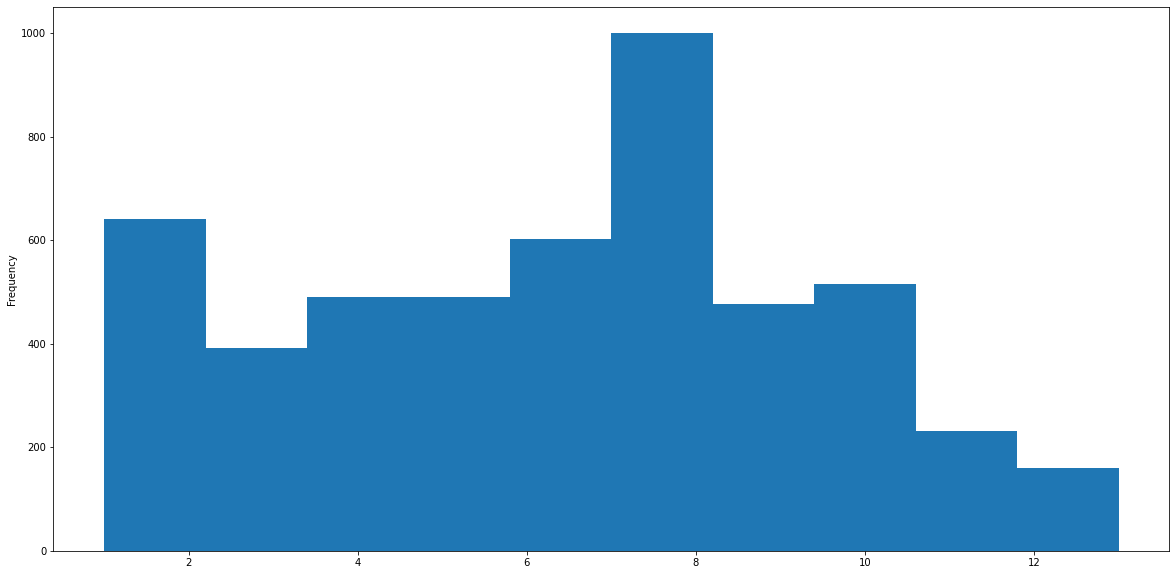

In [16]:
df.groupby('user_id').event.count().plot.hist()

<AxesSubplot:ylabel='Frequency'>

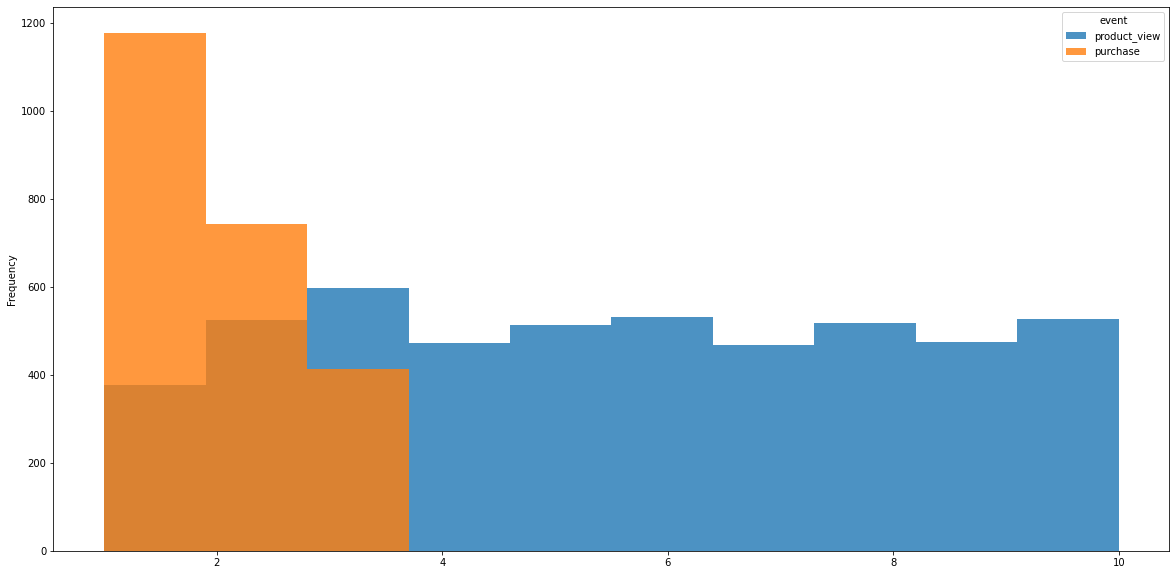

In [17]:
df.groupby(['user_id', 'event']).event.count().unstack().plot.hist(alpha=0.8)

- Proportion of purchases

<AxesSubplot:ylabel='Frequency'>

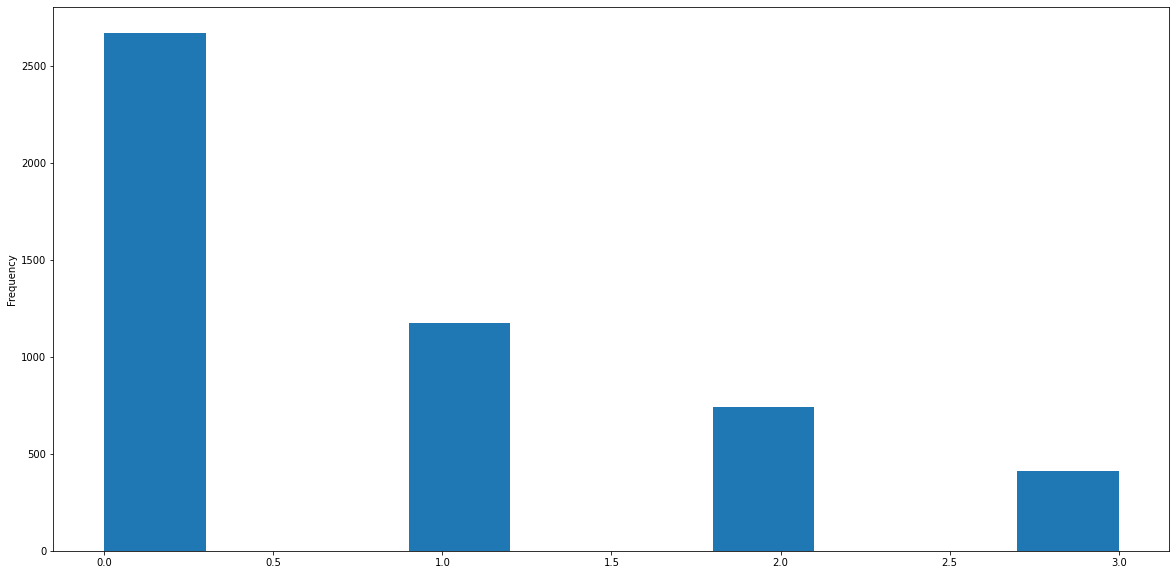

In [18]:
users_actions = df.groupby('user_id').event.value_counts().unstack().fillna(0)
users_actions['purchase'].plot.hist()

In [19]:
sum(users_actions.purchase > 0) *100 / N_USER

46.62

### Prices

- Distribution of the prices

<AxesSubplot:>

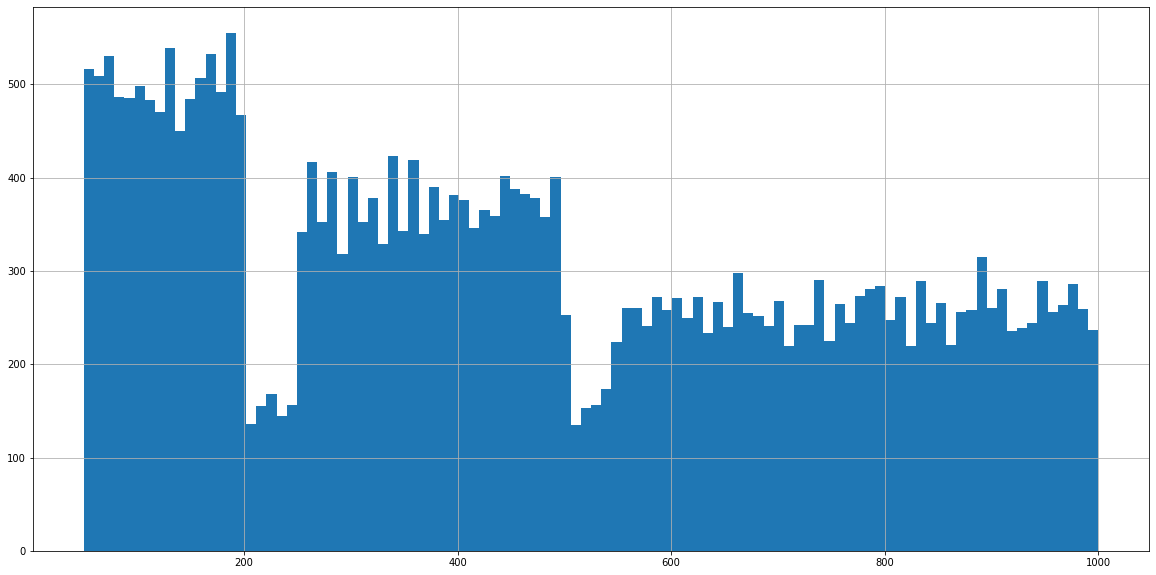

In [20]:
df.price.hist(bins=100)

There seems to be 3 distinct categories of products

- What are the price of items viewed and items purchased

<AxesSubplot:ylabel='Frequency'>

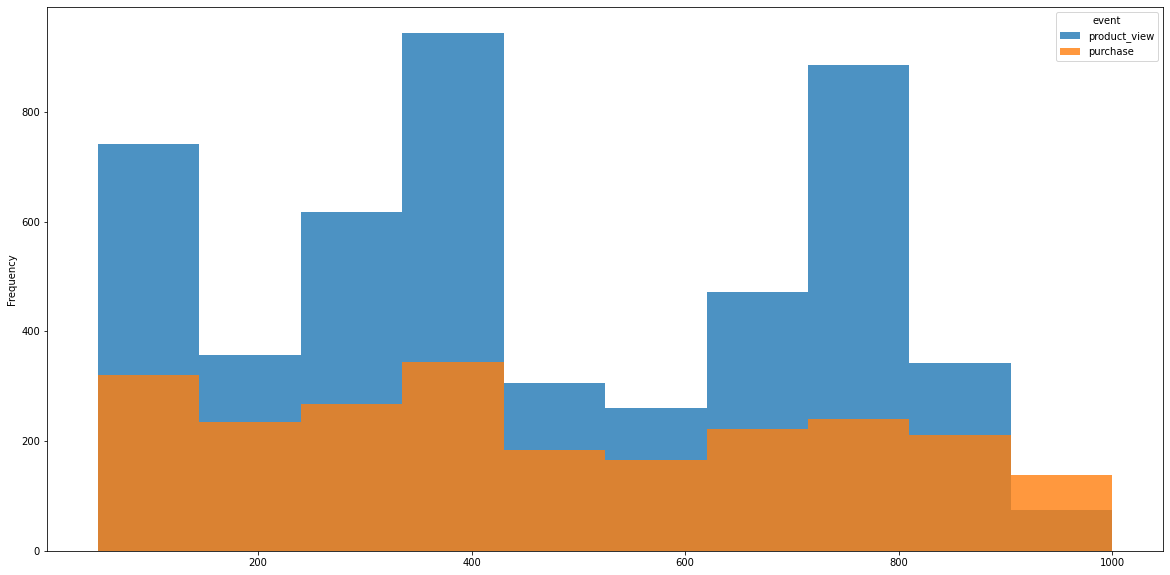

In [21]:
df.groupby(['user_id', 'event']).price.mean().unstack().plot.hist(alpha=0.8)

### Size

- Distribution of the sizes

<AxesSubplot:>

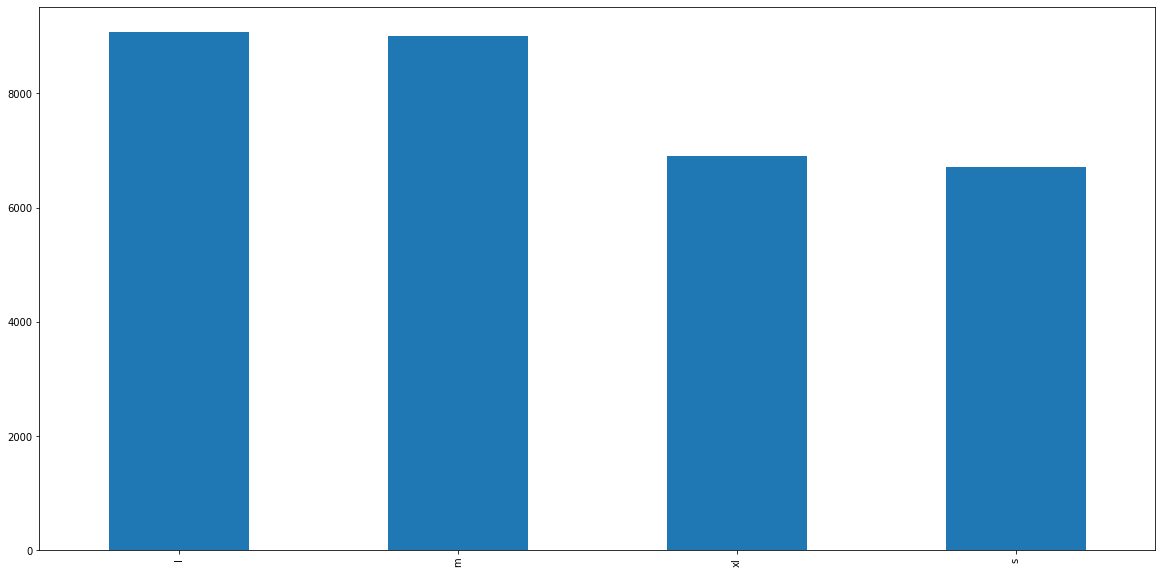

In [22]:
df['size'].value_counts().plot.bar()

- Proportion of sessions with the same size value

In [23]:
same_size_session_df = df.groupby(['user_id', 'session_id']).first()
sum(same_size_session_df['mean_size'].isin(same_size_session_df['mode_size']))*100 / len(same_size_session_df)

71.92448233861145

 - Proportion of users with same size

In [24]:
same_size_session_df = df.groupby(['user_id', 'session_id']).first()
sum(same_size_session_df['mean_size'].isin(same_size_session_df['mode_size']))*100 / len(same_size_session_df)

71.92448233861145

In [25]:
sum(df.groupby(['user_id']).size_int.nunique() == 1) * 100 / N_USER

59.18

This gives us an hint about session. People could by things for other people or having different size for different kind of products.

## Predictions

### Size

Let's observe the number of different size per user:

In [26]:
df.groupby('user_id').size_int.nunique().rename('n_unique_size').value_counts()

1    2959
2    1624
3     216
4     201
Name: n_unique_size, dtype: int64

A majority has only 1 size and it would be safe to predict this size as their main size. When multiple sizes occur, we should rely on the frequency to estimate the probability of each size

###### Example

In [27]:
df_example = df.query('user_id == "c444f4d096382a889e590974da7b4e3f4e4ff75e8c227718ecb7db0424017c3a"')
df_example

,user_id,event,price,size,size_int,session_id,has_order,mean_size,mean_price,mode_size,n_action
9224,c444f4d096382a889e590974da7b4e3f4e4ff75e8c2277...,product_view,618,m,2,0,True,2.7,739.7,3,10
9225,c444f4d096382a889e590974da7b4e3f4e4ff75e8c2277...,product_view,616,s,1,0,True,2.7,739.7,3,10
9226,c444f4d096382a889e590974da7b4e3f4e4ff75e8c2277...,product_view,958,xl,4,0,True,2.7,739.7,3,10
9227,c444f4d096382a889e590974da7b4e3f4e4ff75e8c2277...,product_view,709,m,2,0,True,2.7,739.7,3,10
9228,c444f4d096382a889e590974da7b4e3f4e4ff75e8c2277...,product_view,526,l,3,0,True,2.7,739.7,3,10
9229,c444f4d096382a889e590974da7b4e3f4e4ff75e8c2277...,product_view,665,xl,4,0,True,2.7,739.7,3,10
9230,c444f4d096382a889e590974da7b4e3f4e4ff75e8c2277...,product_view,838,m,2,0,True,2.7,739.7,3,10
9231,c444f4d096382a889e590974da7b4e3f4e4ff75e8c2277...,product_view,873,l,3,0,True,2.7,739.7,3,10
9232,c444f4d096382a889e590974da7b4e3f4e4ff75e8c2277...,product_view,797,l,3,0,True,2.7,739.7,3,10
9233,c444f4d096382a889e590974da7b4e3f4e4ff75e8c2277...,purchase,797,l,3,0,True,2.7,739.7,3,10


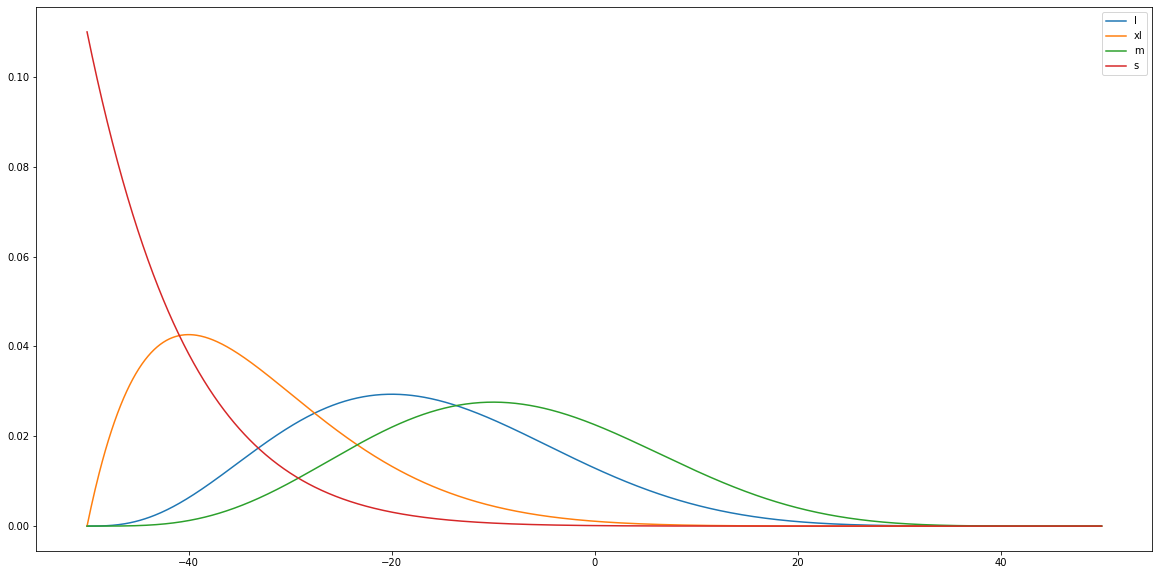

In [28]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

for i in df["size"].unique():
    a = sum(df_example['size'] == i)
    b = len(df_example) - a
    x = np.arange (-50, 50, 0.1)
    y = beta.pdf(x,a,b, scale=100, loc=-50)
    plt.plot(x,y, label=i)
plt.legend()

These are the beta distribution for every size this user interacted with. Sampling along these distribution multiple time will give us a probability of liking each size.

We can also view that with a fake example and a

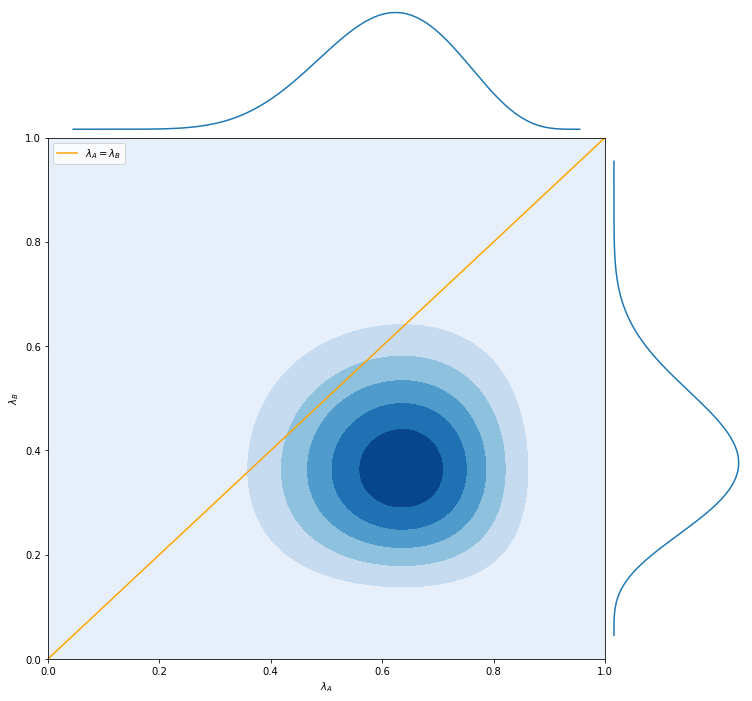

In [29]:
from scipy import stats

import matplotlib.gridspec as gridspec

N_plot = 1000
    
X = np.linspace(0, 1,N_plot)

posterior_a = stats.beta.pdf(X, 
                             8,
                             5)
posterior_b = stats.beta.pdf(X, 
                             5,
                             8)

A, B = np.meshgrid(posterior_a, posterior_b)

Z = A * B

f = plt.figure(figsize=(15,12))
gs0 = gridspec.GridSpec(5, 6, figure=f, wspace=.02, hspace=.02)
ax1 = f.add_subplot(gs0[1:, :-2])
ax2 = f.add_subplot(gs0[:1, :-2])
ax3 = f.add_subplot(gs0[1:, -2:-1])

ax1.contourf(X, X, Z, cmap= 'Blues')
ax1.plot(X, X, color = 'orange', label = '$\lambda_A = \lambda_B$')
ax2.plot(X, posterior_a)
ax3.plot(posterior_b, X)

ax1.set_xlabel('$\lambda_A$')
ax1.set_ylabel('$\lambda_B$')

ax3.set_axis_off()
ax2.set_axis_off()

ax1.legend()
plt.show()

###### Application

In [30]:
def sample(n_actions, count_s, count_m, count_l, count_xl):
    """
    This function takes the frequency of each size for one user
    and sample the probability using beta distributions
    A mask of the best value is returned
    """
    sampling = []
    for i in [count_s, count_m, count_l, count_xl]:
        if i == n_actions:
            sampling.append(1)
        elif i == 0:
            sampling.append(0)
        else:
            sampling.append(np.random.beta(i, n_actions - i))
    res = np.zeros(4)
    res[np.array(sampling).argmax()] = 1
    return res


def get_proba(user_id, count_s, count_m, count_l, count_xl):
    """
        Use previous sampling to average the prefered size of the user
    """
    n_actions = count_s + count_m + count_l + count_xl
    probas = [sample(n_actions, count_s, count_m, count_l, count_xl) for i in range(1000)]
    probas = (np.array(probas).sum(axis=0) / 1000).round(2)
                
    return {
        "user_id": user_id,
        "size_s": probas[0],
        "size_m": probas[1],
        "size_l": probas[2],
        "size_xl": probas[3],
    }

In [31]:
# Apply the get_proba function to every users
size_prediction_df = (
    df.groupby('user_id')['size']
      .value_counts()
      .unstack()
      .add_prefix('count_')
      .reset_index()
      .fillna(0)
      .apply(lambda x: get_proba(**x.to_dict()), axis=1)
      .apply(pd.Series)
      .set_index('user_id')
)
size_prediction_df

,size_s,size_m,size_l,size_xl
user_id,,,,
0003e353c219598fb1c1cd1a5c2873bbc64e2a973e594b4ce9346461f0f53705,0.0,0.00,0.00,1.0
00253fb09b8d40fe3594660db0bae6e2ad1907686f53789f1d18a8fa1f6da547,0.0,0.85,0.15,0.0
00265617b338e660f106406fbf5a8f28dc24296db6d82eb02680a5479601a14d,0.0,1.00,0.00,0.0
002a8623bc303ed3ff5034e28104af2b04e3af0e3902e4498a6406f1437c4ca0,0.5,0.50,0.00,0.0
005b8ccdb27416ecec480a05e0a0f72968546ad2edd2ff0c433d4c4b3456ad20,0.0,1.00,0.00,0.0
...,...,...,...,...
ffc4127b844adaeeddafa7697cf0fac68f521f1f25bf95e811da81602631b544,0.0,1.00,0.00,0.0
ffd02895b8cdb693f30b9f1911f99a7266d0be8020e9cb38c752d381eb144dd5,0.0,0.00,0.00,1.0
ffd32f4e58574db637754d4abc58ee93c5b98b98e31e3975d5a5c75f6349033c,0.0,0.00,0.00,1.0


Let saves these prediction in a json file

In [32]:
size_prediction_df.reset_index().to_json('data/size_predictions.json', lines=True, orient="records")

### Price

#### Simple Solution

Simple bounds using mean and standard deviation

In [33]:
price_prediction_df = df.groupby('user_id')['price'].apply(lambda x: [np.mean(x) - np.std(x), np.mean(x) + np.std(x)]).apply(pd.Series).round()
price_prediction_df.columns = ["lower_bound", "upper_bound"]
price_prediction_df

,lower_bound,upper_bound
user_id,,
0003e353c219598fb1c1cd1a5c2873bbc64e2a973e594b4ce9346461f0f53705,322.0,465.0
00253fb09b8d40fe3594660db0bae6e2ad1907686f53789f1d18a8fa1f6da547,331.0,472.0
00265617b338e660f106406fbf5a8f28dc24296db6d82eb02680a5479601a14d,83.0,83.0
002a8623bc303ed3ff5034e28104af2b04e3af0e3902e4498a6406f1437c4ca0,96.0,110.0
005b8ccdb27416ecec480a05e0a0f72968546ad2edd2ff0c433d4c4b3456ad20,647.0,954.0
...,...,...
ffc4127b844adaeeddafa7697cf0fac68f521f1f25bf95e811da81602631b544,462.0,462.0
ffd02895b8cdb693f30b9f1911f99a7266d0be8020e9cb38c752d381eb144dd5,672.0,867.0
ffd32f4e58574db637754d4abc58ee93c5b98b98e31e3975d5a5c75f6349033c,533.0,881.0


Saving the data

In [34]:
price_prediction_df.reset_index().to_json("data/price_predictions_simple.json", orient="records", lines=True)

#### More complex solution

Let's observe a user with lots of events

In [35]:
df.groupby('user_id')['price'].count().sort_values()

user_id
2842e362a783727e56c4547f952cd5f7b4e807c41fa0dcb4822afd9fd35d29f3     1
55df2d7ff2f4436c1e60ae3adc9359ae8655612270680a84e7a2c7903884a2d7     1
883e7483b9c8b16900e30a9f0e7639d09ac84bf53567f8e6878d327e7eca8432     1
88716ae4e118538bbb7cc89e3ee1e4c63b3fe89ce0333bb912a6ca9012e89d36     1
f6c6c35592320268951526a57ddef21b4a5f59799bdffdd5d6ce00f8a13e792e     1
                                                                    ..
effabf5eae4c1b48f401aae0436fd6adedbe6c4468adf17a359149d8796b5315    13
766459420fa9d5dd4f4ffd91953e82df2b7c9a545f271bf0d06a08ea210a248d    13
1d8e6f127c8fad957edb2c18a970b0c6eb16872421d7f57102884a36b8de926d    13
024f89c5d5bf77fdddfbdb006e5164b92f4a49adad3f1293cb27a8d8818f5497    13
3d77e33d2c26544104d23a7536c88b02b2e0faf4df2b63590df5789e4a89991d    13
Name: price, Length: 5000, dtype: int64

In [36]:
example = df.query('user_id == "3d77e33d2c26544104d23a7536c88b02b2e0faf4df2b63590df5789e4a89991d"')
example

,user_id,event,price,size,size_int,session_id,has_order,mean_size,mean_price,mode_size,n_action
31068,3d77e33d2c26544104d23a7536c88b02b2e0faf4df2b63...,product_view,735,s,1,0,True,1.0,571.777778,1,9
31069,3d77e33d2c26544104d23a7536c88b02b2e0faf4df2b63...,product_view,770,s,1,0,True,1.0,571.777778,1,9
31070,3d77e33d2c26544104d23a7536c88b02b2e0faf4df2b63...,product_view,685,s,1,0,True,1.0,571.777778,1,9
31071,3d77e33d2c26544104d23a7536c88b02b2e0faf4df2b63...,product_view,970,s,1,0,True,1.0,571.777778,1,9
31072,3d77e33d2c26544104d23a7536c88b02b2e0faf4df2b63...,product_view,76,s,1,0,True,1.0,571.777778,1,9
31073,3d77e33d2c26544104d23a7536c88b02b2e0faf4df2b63...,product_view,839,s,1,0,True,1.0,571.777778,1,9
31074,3d77e33d2c26544104d23a7536c88b02b2e0faf4df2b63...,product_view,833,s,1,0,True,1.0,571.777778,1,9
31075,3d77e33d2c26544104d23a7536c88b02b2e0faf4df2b63...,product_view,119,s,1,0,True,1.0,571.777778,1,9
31076,3d77e33d2c26544104d23a7536c88b02b2e0faf4df2b63...,purchase,119,s,1,0,True,1.0,571.777778,1,9
31077,3d77e33d2c26544104d23a7536c88b02b2e0faf4df2b63...,product_view,627,s,1,1,True,1.0,627.000000,1,2


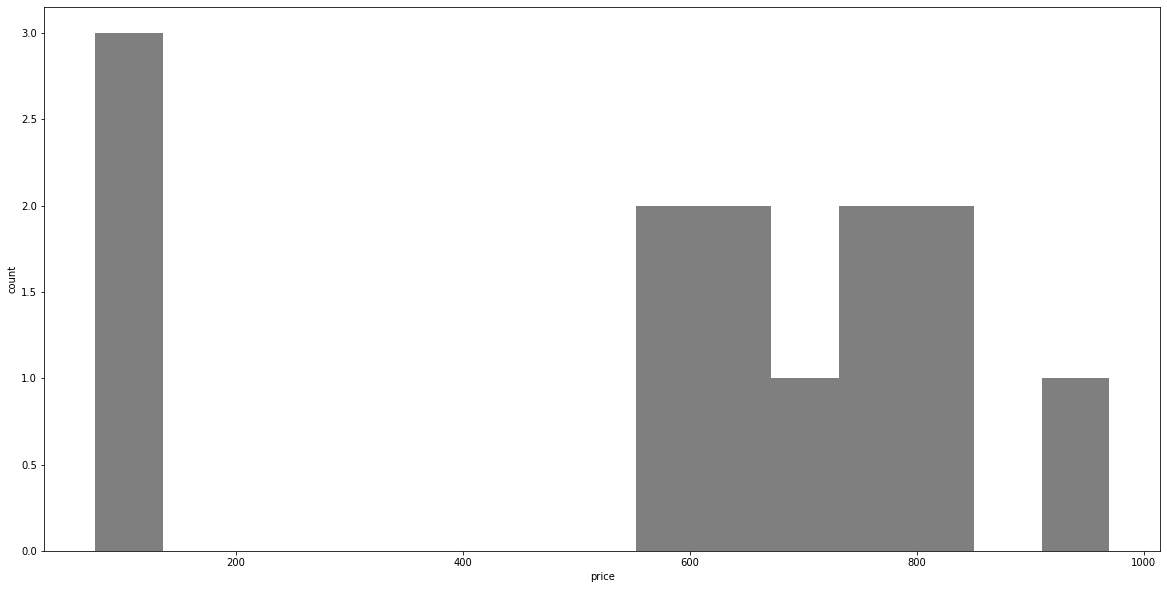

In [37]:
data = example.price.values
plt.hist(data, bins=15, color='black', alpha=.5)
plt.xlabel('price')
plt.ylabel('count')
plt.show()

In [38]:
np.mean(data), np.var(data)

(580.4615384615385, 79839.32544378698)

In [39]:
def gaussian(m, v, x):
    out = (1 / np.sqrt(2*np.pi*v)) * np.exp(-(x - m)**2 / (2*v))
    return out

def gaussian_f(m, v, x):
    out = np.zeros(x.shape)
    for i,xx in enumerate(x):
        out[i] = gaussian(m, v, xx)
    return out

Let's plot possible gaussian distribution which could fit this data

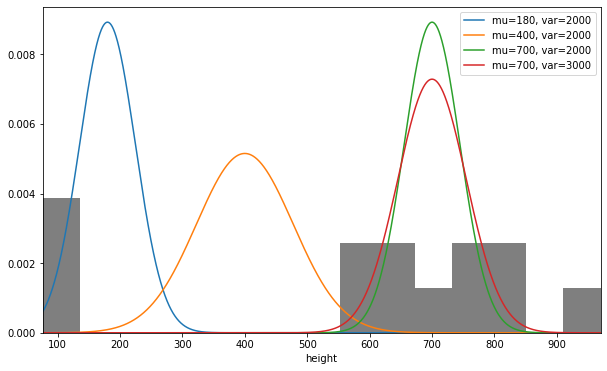

In [40]:
x = np.arange(data.min(), data.max(), 0.01)

plt.figure(figsize=(10,6))
plt.hist(data, bins=15, density=True, color='black',alpha=0.5)
plt.plot(x, gaussian_f(180, 2000, x), label='mu=180, var=2000')
plt.plot(x, gaussian_f(400, 6000, x), label='mu=400, var=2000')
plt.plot(x, gaussian_f(700, 2000, x), label='mu=700, var=2000')
plt.plot(x, gaussian_f(700, 3000, x), label='mu=700, var=3000')
plt.xlim([data.min(), data.max()])
plt.xlabel('height')
plt.legend()
plt.show()

Let's make a grid search on the mean and variance parameters to find the best couple

In [41]:
# Calculation of likelihood function
mus = np.arange(data.min(), data.max(), data.max()//100)
var_s = np.arange(np.var(data)/2, np.var(data)*2, np.var(data)//100)

In [42]:
params = np.zeros((len(mus), len(var_s)))
for i,m in enumerate(mus):
    for j,v in enumerate(var_s):
        p = 1
        for x in data:
            p *= gaussian(m, v, x)
        params[i,j] = p

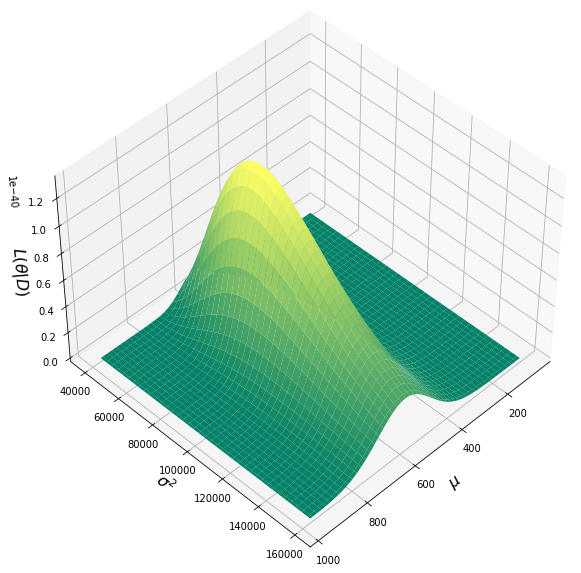

In [43]:
# plot likelihood

X,Y = np.meshgrid(var_s, mus)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y, X, params, cmap='summer')
ax.view_init(azim=45, elev=45)
ax.set_xlabel(r'$\mu$', fontsize=16)
ax.set_ylabel(r'$\sigma^2$', fontsize=16)
ax.set_zlabel(r'$L(\theta|D)$', fontsize=16)
plt.show()

The best parameters can be found using argmax, but currently it will be always the mean and variance values.

In [44]:
X[np.unravel_index(params.argmax(), params.shape)], Y[np.unravel_index(params.argmax(), params.shape)]

(79819.66272189349, 580)